In [5]:

# Zachary Katz
# zachary_katz@mines.edu
# 04 June 2025

"""

Download ATL 11 granule if necessary
Extract example with multiple crossing tracks
"""

# Imports
import earthaccess
from pathlib import Path
import h5py
from astropy.time import Time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from shapely.geometry import Point, Polygon, shape
import shapefile
import cartopy.crs as ccrs
from pyproj import CRS, Transformer
import re
from itertools import combinations

# User-defined path
data_path = './_data/ATL11_LarsenC'
gl_path = '/Users/zachary_katz/Research/Antarctica_Masks/scripps_antarctica_polygons_v1.shp'


In [4]:
auth = earthaccess.login()

In [6]:
# ATL11 over the LARSEN C Ice Shelf
short_name = 'ATL11'
bbox = (-66,-70, -60,-65)

st = '2021-01-01'
ed = '2025-06-01'
# Download ATL11 if necessary
results = earthaccess.search_data(short_name = 'ATL11', 
bounding_box = bbox)
temporal = (st,ed)
print(len(results))
earthaccess.download(results, data_path, provider='POCLOUD')

120


QUEUEING TASKS | : 100%|██████████| 120/120 [00:00<00:00, 1079.28it/s]
PROCESSING TASKS | : 100%|██████████| 120/120 [00:33<00:00,  3.57it/s]
COLLECTING RESULTS | : 100%|██████████| 120/120 [00:00<00:00, 388361.48it/s]


['_data/ATL11_LarsenC/ATL11_000312_0326_006_12.h5',
 '_data/ATL11_LarsenC/ATL11_004110_0326_006_12.h5',
 '_data/ATL11_LarsenC/ATL11_005610_0326_006_12.h5',
 '_data/ATL11_LarsenC/ATL11_006412_0326_006_12.h5',
 '_data/ATL11_LarsenC/ATL11_010210_0326_006_12.h5',
 '_data/ATL11_LarsenC/ATL11_011710_0326_006_12.h5',
 '_data/ATL11_LarsenC/ATL11_012512_0326_006_12.h5',
 '_data/ATL11_LarsenC/ATL11_017810_0326_006_12.h5',
 '_data/ATL11_LarsenC/ATL11_018612_0326_006_12.h5',
 '_data/ATL11_LarsenC/ATL11_023910_0326_006_12.h5',
 '_data/ATL11_LarsenC/ATL11_024712_0326_006_12.h5',
 '_data/ATL11_LarsenC/ATL11_030010_0326_006_12.h5',
 '_data/ATL11_LarsenC/ATL11_030812_0326_006_12.h5',
 '_data/ATL11_LarsenC/ATL11_032312_0326_006_12.h5',
 '_data/ATL11_LarsenC/ATL11_036110_0326_006_12.h5',
 '_data/ATL11_LarsenC/ATL11_036912_0326_006_12.h5',
 '_data/ATL11_LarsenC/ATL11_038412_0326_006_12.h5',
 '_data/ATL11_LarsenC/ATL11_042210_0326_006_12.h5',
 '_data/ATL11_LarsenC/ATL11_043710_0326_006_12.h5',
 '_data/ATL1

In [7]:
files = list(Path(data_path).glob('*.h5'))

In [8]:
def plot_shapefile(
    records: list[shapefile._Record],
    shapes: list[shapefile.Shape],
    ax ,
    colors: list[str],
    transform,
    fill: bool = False,
) -> None:
    """
    Plots the given records and shapes on axis ax.

    Parameters
    ----------
    records : list[shapefile._Record]
        Shapely record containing shape classification
    shapes : list[shapefile.Shape]
        Shapely shape points
    ax : cartopy.mpl.geoaxes.GeoAxes
        Axes to polot on
    colors : list[str]
       [Grounded ice color, Ice Shelf color]; Must be length 2
    """
    for record, shape in zip(records, shapes):
        classification = record[field_names.index("Id_text")]
        points = shape.points
        parts = list(shape.parts)
        parts.append(
            len(points)
        )  # Append the end index of the last part of the shapefile
        for i in range(len(parts) - 1):
            part = points[parts[i] : parts[i + 1]]
            if (
                classification == "Isolated island"
                or classification == "Ice rise or connected island"
                or classification == "Grounded ice or land"
            ):
                if fill:
                    ax.fill(*zip(*part), color=colors[0], zorder=2,transform=transform)
                else:
                    ax.plot(*zip(*part), color=colors[0], linewidth=1.5, zorder=2,transform=transform)
            elif classification == "Ice shelf":
                if fill:
                    ax.fill(*zip(*part), color=colors[1], zorder=2,transform=transform)
                else:
                    ax.plot(*zip(*part), color=colors[1], linewidth=1.5, zorder=2,transform=transform)
            else:
                print(f"Unknown classification: {classification}")

In [17]:
# Load ross polygon
ice_shelf_polygons = []
grounded_polygons = []

sf = shapefile.Reader(gl_path)
fields = sf.fields[1:] # Skip deletion flag
field_names = [field[0] for field in fields]
records = sf.records()
shapes = sf.shapes()

for record, shape in zip(records, shapes):
    classification = record[field_names.index("Id_text")]
    points = shape.points
    parts = list(shape.parts)
    parts.append(len(points))  # Append the end index of the last part
    for i in range(len(parts) - 1):
        part = points[parts[i]:parts[i + 1]]
        polygon = shapely.Polygon(part)
        if classification == "Isolated island" or classification == "Ice rise or connected island" or classification == "Grounded ice or land":
            if polygon.is_valid:
                grounded_polygons.append(polygon)
        elif classification == "Ice shelf":
            if polygon.is_valid:
                ice_shelf_polygons.append(polygon)
        else:
            print(f"Unknown classification: {classification}")


#bbox = [-200000,-1800000,0,-800000] #Ross
bbox = [-2020000,950000,-1940000,1050000] # GeorgeVI
#bbox = [] # Larsen C
# Filter records and shapes to bbox
filtered_records = []
filtered_shapes = []
for record, shape in zip(records, shapes):
    shape_bbox = shape.bbox
    # Checks if any part of the shape is within the bounding box
    classification = record[field_names.index("Id_text")]
    if (
        shape_bbox[0] < bbox[2]
        and shape_bbox[2] > bbox[0]
        and shape_bbox[1] < bbox[3]
        and shape_bbox[3] > bbox[1]
    ) and  classification == "Ice shelf":
        filtered_records.append(record)
        filtered_shapes.append(shape)

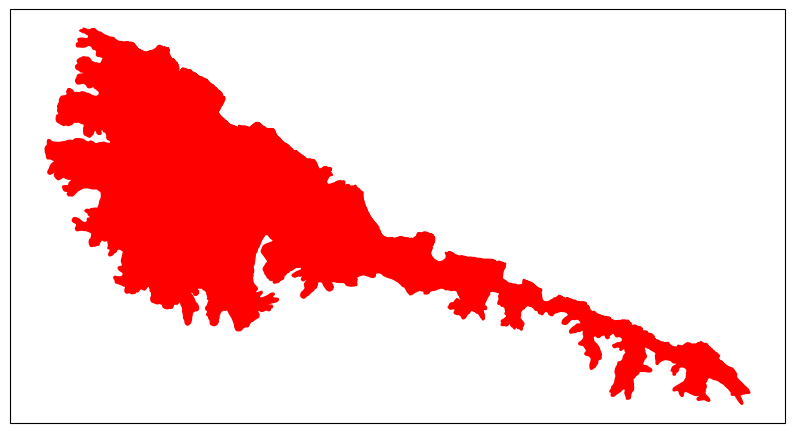

In [18]:
ps71_projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={'projection': ps71_projection},
)
plot_shapefile(filtered_records, filtered_shapes, ax, ["lightgray", "red"], ps71_projection, fill=True)

In [19]:
def ll2xy(lon: list[float], lat: list[float]) -> tuple[list[float], list[float]]:
    """
    Transform coordinates from input geodetic coordinates (lon, lat)
    to output Antarctic Polar Stereographic coordinates (x, y).
    Can also take single floats.

    Parameters
    ----------
    lon: list[float]
         Geodetic longitude in EPSG:4326
    lat: list[float]
         Geodetic latitude in EPSG:4326

    Returns
    -------
    x: list[float]
       Antarctic Polar Stereographic (EPSG:3031) x
    y: list[float]
       Antarctic Polar Stereographic (EPSG:3031) y
    """

    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy=True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

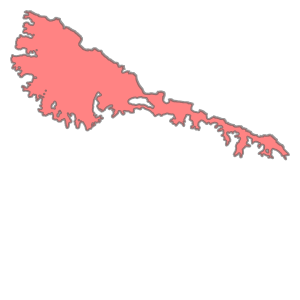

In [20]:
from shapely.geometry import Point, Polygon, shape
ross = shape(filtered_shapes[0].__geo_interface__)
ross

In [21]:
### STREAMLINE EVERYTHING BELOW IN 20 FILE CHUNKS ###


# Each reference track pair is a group
group = ['/pt1/','/pt2/','/pt3/']

chunk_size = 20
num_chunks = (len(files) + chunk_size - 1) // chunk_size  

csv_index = 0
for chunk_idx in range(num_chunks):
    start_idx = chunk_idx * chunk_size
    end_idx = min(start_idx + chunk_size, len(files))
    file_chunk = files[start_idx:end_idx]

    print(f"Processing chunk {chunk_idx+1}/{num_chunks} with {len(file_chunk)} files...")

    # Make array of ATL11 data
    print("ATL11 Data Array")
    data_arr = []
    # Loop over files
    for file in file_chunk:
        # Loop over pairs
        for i, g in enumerate(group):
            data = {}
            # Load variables into dictionary list
            with h5py.File(file, 'r') as fi:

                data['t_ref'] = fi['/ancillary_data/atlas_sdp_gps_epoch'][:] # ICESat-2 reference epoch
                data['filename'] = file
                data['group'] = g
            
                # Crossing track data
                data['x_q_flag'] = fi[g+'crossing_track_data/atl06_quality_summary'][:] #0 likely no problem; 1 problems #See table 4-4 in IceSat2 ATL11 ATBD
                data['x_lat'] = fi[g+'crossing_track_data/latitude'][:] # Latitude [degrees]
                data['x_lon'] = fi[g+'crossing_track_data/longitude'][:] # Longitude [degrees]
                data['x_h_corr'] = fi[g+'crossing_track_data/h_corr'][:] # Mean corrected height [m]
                data['x_t_dt'] = fi[g+'crossing_track_data/delta_time'][:] # GPS seconds since reference epoch
                data['x_cycle_number'] = fi[g+'crossing_track_data/cycle_number'][:] # Cycle
                data['x_rgt'] = fi[g+'crossing_track_data/rgt'][:] # Reference ground track
                data['x_spot_crossing'] = fi[g+'crossing_track_data/spot_crossing'][:] # Spot  number
                data['x_ref_pt'] = fi[g+'crossing_track_data/ref_pt'][:] # Reference point
                data['x_x'], data['x_y'] = ll2xy(data['x_lon'],data['x_lat'])


                time_temp = data['t_ref'] + data['x_t_dt']
                data['x_time'] = Time(time_temp, format='gps').iso # Convert to readable time
                
                # Main track data
                data['lat'] = fi[g+'/latitude'][:] # Latitude [degrees]
                data['lon'] = fi[g+'/longitude'][:] # Longitude [degrees]
                data['h_corr'] = fi[g+'/h_corr'][:] # Mean corrected height [m]
                data['t_dt'] = fi[g+'/delta_time'][:] # GPS seconds since reference epoch
                data['q_flag'] = fi[g+'/quality_summary'][:] #0 likely no problem; 1 problems #See table 4-4 in IceSat2 ATL11 ATBD
                data['cycle_number'] = fi[g+'/cycle_number'][:] # Cycle
                data['ref_pt'] = fi[g+'/ref_pt'][:] # Reference point
                time_temp = data['t_ref'] + data['t_dt']
                data['time'] = Time(time_temp, format='gps').iso # Convert to readable time

                data['x'], data['y'] = ll2xy(data['lon'],data['lat'])
                
            data_arr.append(data)

    print("Downscaling to Ross Ice Shelf")
    # Downscale data so only in ross polygon
    for data in data_arr[:]:
        inside_mask = []
        x_inside_mask = []
        for xi, yi in zip(data['x'], data['y']):
            point = Point(xi, yi)
            inside_mask.append(ross.contains(point))
        data['inside_mask'] = inside_mask

        for xi, yi in zip(data['x_x'], data['x_y']):
            point = Point(xi, yi)
            x_inside_mask.append(ross.contains(point))

        data['x_inside_mask'] = x_inside_mask

    print("Creating Crossover Table")
    # Loop over each track and create crossover table
    dfs = []
    for data in data_arr[:]:
        i = 0
        for ref_pt in data['ref_pt'][data['inside_mask']]:

            mskx = (data['x_ref_pt'] == ref_pt) & (data['x_t_dt'] < 2e300)
            msk = (data['ref_pt'] == ref_pt)
            mskd_lat = data['lat'][msk]
            mskd_lon = data['lon'][msk]
            mskd_xlat = data['x_lat'][mskx]
            mskd_xlon = data['x_lon'][mskx]
            mskd_xt = data['x_time'][mskx]
            mskd_xcycle = data['x_cycle_number'][mskx]
            mskd_xrgt = data['x_rgt'][mskx]

            mskd_t = data['time'][msk]
            mskd_tdt = data['t_dt'][msk]
            msk_t = mskd_tdt < 2e300
            mskd_t = mskd_t[msk_t]

            mskd_h = data['h_corr'][msk]
            mskd_h = mskd_h[msk_t]
            mskd_xh = data['x_h_corr'][mskx]
            
            mskd_q = data['q_flag'][msk]
            mskd_q = mskd_q[msk_t]
            mskd_xq = data['x_q_flag'][mskx]

            msk_t = msk_t.flatten()
            mskd_cycle = data['cycle_number'][msk_t]

            mskd_lon = np.ones(len(mskd_t)) * mskd_lon
            mskd_lat = np.ones(len(mskd_t)) * mskd_lat

            match = re.search(r'ATL11_(\d{4})', str(data['filename']))
            mskd_rgt = np.ones(len(mskd_t),dtype=int) * int(match.group(1))
            
            #print(len(mskd_xlat),len(mskd_xlon),len(mskd_xt),len(mskd_xcycle),len(mskd_xh))
            #print(len(mskd_lat),len(mskd_lon),len(mskd_t),len(mskd_cycle),len(mskd_h[0]))
            if len(mskd_xlat) > 5:
                df1 = pd.DataFrame(
                {
                    'lat': mskd_xlat,
                    'lon': mskd_xlon,
                    'time': mskd_xt,
                    'height': mskd_xh,
                    'q_flag': mskd_xq,
                    'cycle_number': mskd_xcycle,
                    'rgt': mskd_xrgt
                }
                )
                df2 = pd.DataFrame(
                    {
                        'lat': mskd_lat,
                        'lon': mskd_lon,
                        'time': mskd_t,
                        'height': mskd_h,
                        'q_flag': mskd_q,
                        'cycle_number': mskd_cycle,
                        'rgt': mskd_rgt
                    }
                )
                df = pd.concat([df1,df2], ignore_index=True)
                df = df.sort_values(by=['time']).reset_index(drop=True);
                dfs.append(df)

    print("Generate all Combinations at each point")
    # Generate all combos for laurie
    combined_rows = []
    for iter, df in enumerate(dfs[:]):
        #print(iter)
        # Iterate over all unique pairs of rows
        rows = df.reset_index()
        
        lat_arr = rows['lat'].values
        lon_arr = rows['lon'].values
        time_arr = rows['time'].values
        height_arr = rows['height'].values
        q_flag_arr = rows['q_flag'].values
        cycle_arr = rows['cycle_number'].values
        rgt_arr = rows['rgt'].values

        pairs = list(combinations(range(len(rows)), 2))

        # Prepare list to store new rows
        for i, j in pairs:
            new_row = [
                lat_arr[i],
                lon_arr[i],
                time_arr[i],
                time_arr[j],
                height_arr[i],
                height_arr[j],
                q_flag_arr[i],
                q_flag_arr[j],
                cycle_arr[i],
                cycle_arr[j],
                rgt_arr[i],
                rgt_arr[j]
            ]
            combined_rows.append(new_row)

        columns = [
        'lat', 'lon', 'time_1', 'time_2', 'height_1', 'height_2',
        'quality_1', 'quality_2', 'cycle_1', 'cycle_2', 'rgt_1', 'rgt_2'
    ]

    print("Make into large dataframe")
    laurie_df = pd.DataFrame(combined_rows[:], columns=columns)

    print("Saving Dataframe")
    laurie_df.to_csv(f"Larsen_ATL11Crossovers_{csv_index}", index=False)
    csv_index += 1

Processing chunk 1/3 with 20 files...
ATL11 Data Array


/Users/zachary_katz/Research/atl11-crossovers/.venv/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/Research/atl11-crossovers/.venv/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/Research/atl11-crossovers/.venv/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/Research/atl11-crossovers/.venv/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/Research/atl11-crossovers/.venv/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/Research/atl11-crossovers/.venv/lib/pytho

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 2/3 with 20 files...
ATL11 Data Array


/Users/zachary_katz/Research/atl11-crossovers/.venv/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/Research/atl11-crossovers/.venv/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/Research/atl11-crossovers/.venv/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/Research/atl11-crossovers/.venv/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/Research/atl11-crossovers/.venv/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/Research/atl11-crossovers/.venv/lib/pytho

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe
Processing chunk 3/3 with 20 files...
ATL11 Data Array


/Users/zachary_katz/Research/atl11-crossovers/.venv/lib/python3.12/site-packages/astropy/time/utils.py:160: RuntimeWarning: overflow encountered in multiply
  x = a * b
/Users/zachary_katz/Research/atl11-crossovers/.venv/lib/python3.12/site-packages/astropy/time/utils.py:183: RuntimeWarning: overflow encountered in multiply
  c = 134217729.0 * a  # 2**27+1.
/Users/zachary_katz/Research/atl11-crossovers/.venv/lib/python3.12/site-packages/astropy/time/utils.py:185: RuntimeWarning: invalid value encountered in subtract
  ah = c - abig
/Users/zachary_katz/Research/atl11-crossovers/.venv/lib/python3.12/site-packages/astropy/time/utils.py:139: RuntimeWarning: invalid value encountered in subtract
  ea = x - eb  # avirtual in Shewchuk
/Users/zachary_katz/Research/atl11-crossovers/.venv/lib/python3.12/site-packages/astropy/time/utils.py:140: RuntimeWarning: invalid value encountered in subtract
  eb = b - eb  # broundoff in Shewchuk
/Users/zachary_katz/Research/atl11-crossovers/.venv/lib/pytho

Downscaling to Ross Ice Shelf
Creating Crossover Table
Generate all Combinations at each point
Make into large dataframe
Saving Dataframe


In [ ]:
# Compare crossover point to CATS
